# Project using Logistic Regression to predict whether it will rain or not

# Importing the important libraries

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Downloading the data

In [5]:
rain_df = pd.read_csv("../RainTomorrow/weatherAUS.csv")
rain_df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [6]:
rain_df.shape

(145460, 23)

The dataset contains 145460 rows and 23 columns. It has data, categorical and numeric columns. We want to create a model to predict the value in the column RainTomorrow.
Let's check the info about all the columns.

In [7]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

We discard the rows where the value of RainTomorrow or RainToday is missing to make our analysis and modeling simplier.

In [8]:
rain_df.dropna(subset=["RainToday", "RainTomorrow"], inplace=True)

# Exploratory Data Analysis and Visualization


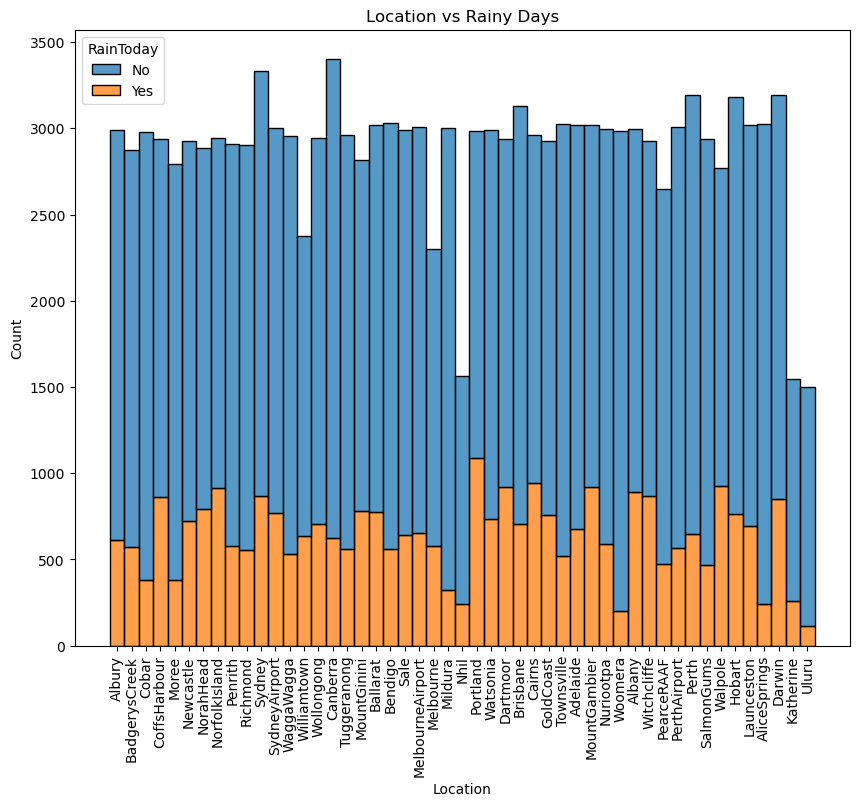

In [9]:
plt.figure(figsize=(10,8))
sns.histplot(data = rain_df, x = "Location", hue = "RainToday", multiple="stack")
plt.xticks(rotation = 90)
plt.title("Location vs Rainy Days")
plt.show()

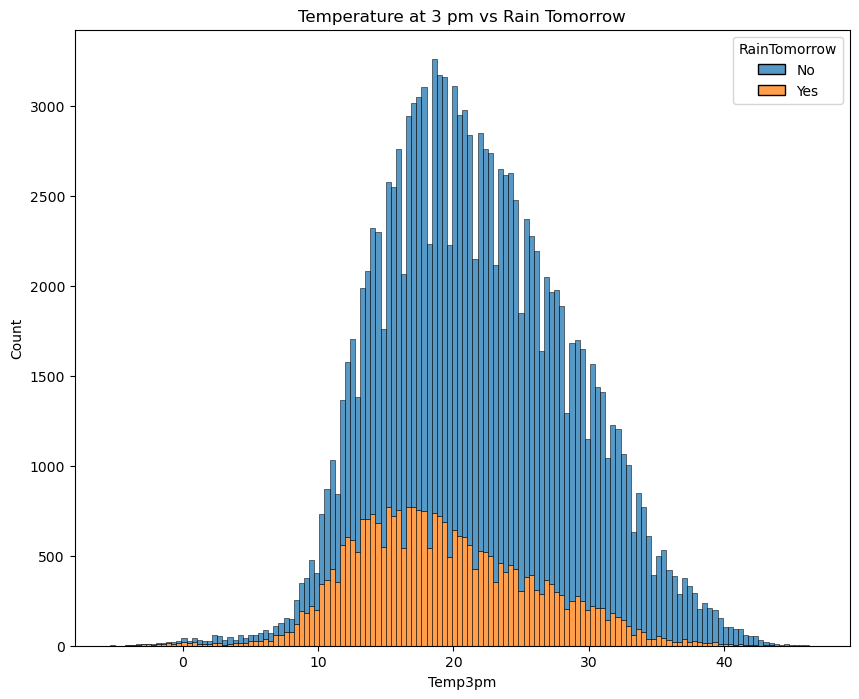

In [10]:
plt.figure(figsize=(10,8))
sns.histplot(data = rain_df, x = "Temp3pm", hue = "RainTomorrow", multiple="stack")
plt.title("Temperature at 3 pm vs Rain Tomorrow")
plt.show()

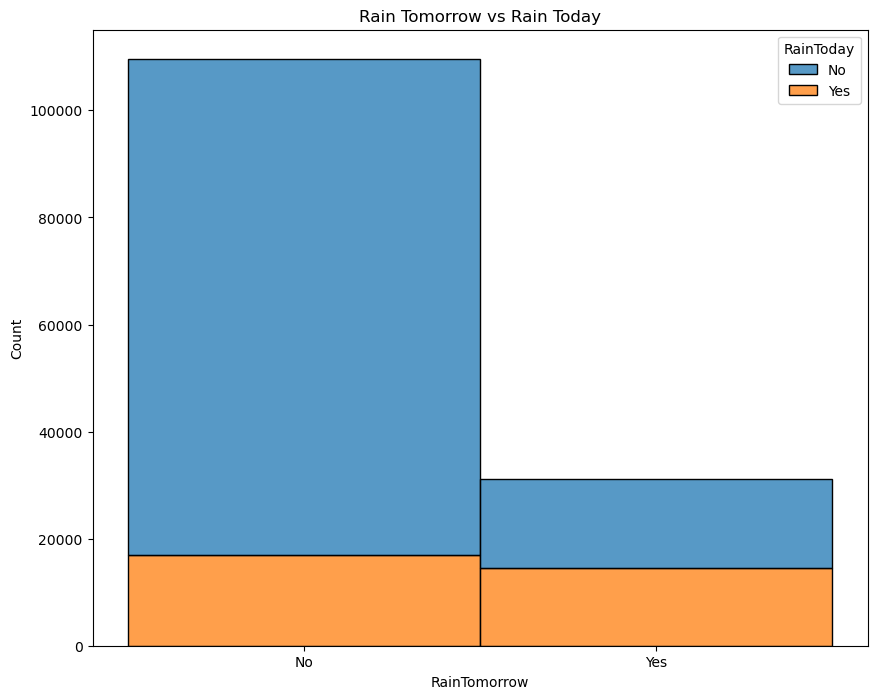

In [11]:
plt.figure(figsize=(10,8))
sns.histplot(data = rain_df, x = "RainTomorrow", hue = "RainToday", multiple="stack")
plt.title("Rain Tomorrow vs Rain Today")
plt.show()

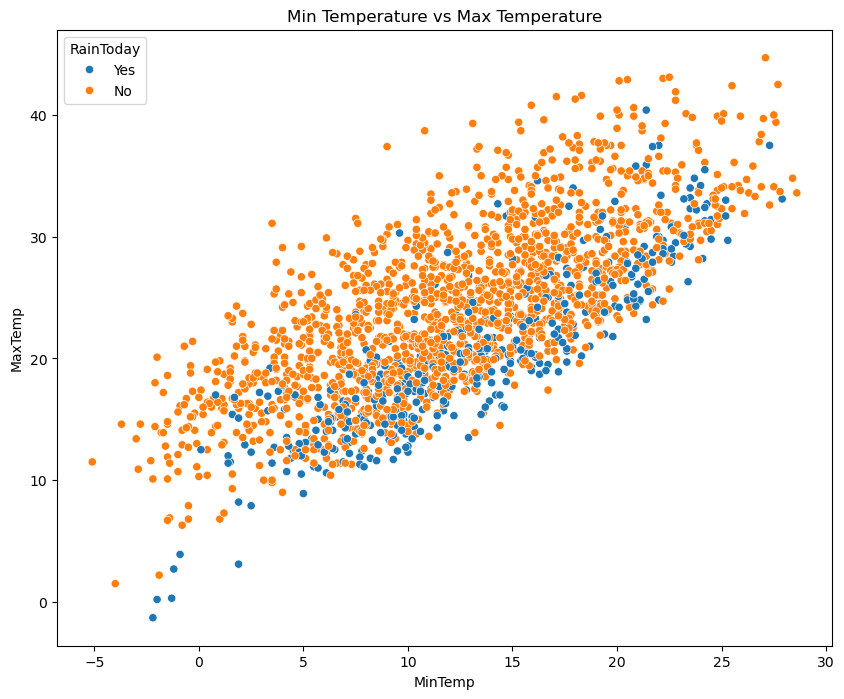

In [12]:
plt.figure(figsize=(10,8))
sns.scatterplot(rain_df.sample(2000), x = "MinTemp", y = "MaxTemp", hue = "RainToday")
plt.title("Min Temperature vs Max Temperature")
plt.show()

In [13]:
plt.figure(figsize=(10,8))
sns.scatterplot(rain_df.sample(2000), x = "Temp3pm", y = "Humidity3pm", hue = "RainTomorrow")
plt.title("Temp (3pm) vs Humidity (3pm)")
plt.show()

# Training, validation and Test Sets
It is quite common to split the dataset into three parts:
* **Training set**: It is used to train the model, compute the loss and adjust the weights of model using an optimization technique.
* **Validation set**: It is used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization, etc.), and pick the best version of the model.
* **Test set**: It is used to compare differrent models and reporte the final accuracy of the model.

It can be around 60% of the data for the training set, 20% for the validation set and 20% for the test set.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_val_df, test_df = train_test_split(rain_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [16]:
print("train_df.shape: ", train_df.shape)
print("val_df.shape: ", val_df.shape)
print("test_df.shape: ", test_df.shape)


train_df.shape:  (84471, 23)
val_df.shape:  (28158, 23)
test_df.shape:  (28158, 23)


We can use the Data Column in the dataset to create another column for year. We are going to pick the last two years for the test set, and one year before it for the validation set.

In [17]:
plt.title("No. of Rows per Year")
sns.countplot(x = pd.to_datetime(rain_df.Date).dt.year)

<AxesSubplot:title={'center':'No. of Rows per Year'}, xlabel='Date', ylabel='count'>

In [18]:
year = pd.to_datetime(rain_df.Date).dt.year

train_df = rain_df[year < 2015]
val_df = rain_df[year == 2015]
test_df = rain_df[year > 2015]

In [19]:
print("train_df.shape = ", train_df.shape)
print("val_df.shape = ", val_df.shape)
print("test_df.shape = ", test_df.shape)

train_df.shape =  (97988, 23)
val_df.shape =  (17089, 23)
test_df.shape =  (25710, 23)


In [20]:
train_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
144548  2014-12-27    Uluru     16.9     33.2       0.0          NaN   
144549  2014-12-28    Uluru     15.1     36.8       0.0          NaN   
144550  2014-12-29    Uluru     17.3     37.8       0.0          NaN   
144551  2014-12-30    Uluru     20.1     38.5       0.0          NaN   
144552  2014-12-31    Uluru     22.5     39.6       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
144548       NaN         SSE           43.0        ESE  ...        22.0   
144549       NaN          NE           31.0        ENE  ...        16.0   
144550       NaN         ESE           39.0        ESE  ...        15.0   
144551       NaN         ESE           43.0        ESE  ...        22.0   
144552       NaN         WNW           76.0        ENE  ...        16.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
144548         13.0       1014.1       1009.8       NaN       NaN     23.7   
144549          8.0       1012.6       1007.6       NaN       NaN     28.9   
144550          8.0       1011.9       1008.0       NaN       NaN     29.7   
144551          9.0       1014.0       1009.2       NaN       NaN     29.8   
144552          9.0       1012.1       1006.2       NaN       NaN     30.1   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
144548     31.8         No            No  
144549     34.8         No            No  
144550     35.7         No            No  
144551     37.2         No            No  
144552     37.4         No            No  

[97988 rows x 23 columns]

In [21]:
val_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
2133    2015-01-01   Albury     11.4     33.5       0.0          NaN   
2134    2015-01-02   Albury     15.5     39.6       0.0          NaN   
2135    2015-01-03   Albury     17.1     38.3       0.0          NaN   
2136    2015-01-04   Albury     26.0     33.1       0.0          NaN   
2137    2015-01-05   Albury     19.0     35.2       0.0          NaN   
...            ...      ...      ...      ...       ...          ...   
144913  2015-12-27    Uluru     20.5     34.7       0.0          NaN   
144914  2015-12-28    Uluru     18.0     36.4       0.0          NaN   
144915  2015-12-29    Uluru     17.5     37.1       0.0          NaN   
144916  2015-12-30    Uluru     20.0     38.9       0.0          NaN   
144917  2015-12-31    Uluru     19.3     37.4       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
2133         NaN         WSW           30.0        ESE  ...        45.0   
2134         NaN          NE           56.0        ESE  ...        45.0   
2135         NaN         NNE           48.0         NE  ...        35.0   
2136         NaN         NNE           41.0        ESE  ...        46.0   
2137         NaN           E           33.0        SSE  ...        60.0   
...          ...         ...            ...        ...  ...         ...   
144913       NaN           E           52.0        ESE  ...        23.0   
144914       NaN         ESE           54.0          E  ...        17.0   
144915       NaN           E           56.0          E  ...        12.0   
144916       NaN           E           59.0          E  ...        12.0   
144917       NaN          SE           56.0        ESE  ...        46.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
2133           14.0       1013.5       1011.0       NaN       NaN     21.0   
2134           12.0       1016.0       1012.4       NaN       NaN     25.6   
2135           19.0       1017.9       1012.3       NaN       NaN     29.2   
2136           37.0       1013.6       1012.1       8.0       5.0     27.4   
2137           34.0       1017.4       1014.7       8.0       NaN     25.6   
...             ...          ...          ...       ...       ...      ...   
144913         12.0       1013.2       1010.1       NaN       NaN     24.3   
144914          7.0       1014.7       1010.9       NaN       NaN     26.7   
144915          7.0       1012.6       1007.5       NaN       NaN     28.1   
144916         12.0       1007.2       1002.6       NaN       1.0     31.3   
144917         18.0       1007.3       1003.7       NaN       NaN     25.8   

        Temp3pm  RainToday  RainTomorrow  
2133       32.7         No            No  
2134       38.2         No            No  
2135       37.0         No            No  
2136       30.9         No            No  
2137       32.5         No            No  
...         ...        ...           ...  
144913     33.0         No            No  
144914     35.0         No            No  
144915     34.7         No            No  
144916     38.4         No            No  
144917     35.8         No            No  

[17089 rows x 23 columns]

In [22]:
test_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
2498    2016-01-01   Albury     20.4     37.6       0.0          NaN   
2499    2016-01-02   Albury     20.9     33.6       0.4          NaN   
2500    2016-01-03   Albury     18.4     23.1       2.2          NaN   
2501    2016-01-04   Albury     17.3     23.7      15.6          NaN   
2502    2016-01-05   Albury     15.5     22.9       6.8          NaN   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
2498         NaN         ENE           54.0        NaN  ...        46.0   
2499         NaN         SSE           50.0        SSE  ...        54.0   
2500         NaN         ENE           48.0        ESE  ...        62.0   
2501         NaN         SSE           39.0         SE  ...        74.0   
2502         NaN         ENE           31.0         SE  ...        92.0   
...          ...         ...            ...        ...  ...         ...   
145454       NaN           E           31.0        ESE  ...        59.0   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
2498           17.0       1013.4       1009.2       7.0       3.0     26.1   
2499           30.0       1011.1       1008.4       8.0       8.0     24.8   
2500           67.0       1014.0       1014.8       8.0       8.0     21.8   
2501           65.0       1017.9       1016.5       8.0       8.0     19.2   
2502           63.0       1016.3       1013.9       8.0       8.0     17.2   
...             ...          ...          ...       ...       ...      ...   
145454         27.0       1024.7       1021.2       NaN       NaN      9.4   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   

        Temp3pm  RainToday  RainTomorrow  
2498       36.7         No            No  
2499       31.7         No           Yes  
2500       19.5        Yes           Yes  
2501       21.6        Yes           Yes  
2502       22.2        Yes            No  
...         ...        ...           ...  
145454     20.9         No            No  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  

[25710 rows x 23 columns]

# Identifying Input and Target Columns

Sometimes, not all the columns in a dataset are useful for training a model. In this case, we can ignore the Data column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

We create a list of input columns and also identify the target column.

In [23]:
input_cols = list(train_df.columns)[1:-1]
target_col = "RainTomorrow"

In [24]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [25]:
target_col

'RainTomorrow'

Now, we can create inputs and targets for the training, validation, and test sets for further processing and model training.

In [26]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [27]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [28]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's identity which of the columns are numerical and which ones are categorical.

In [29]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

Some statistics for the numeric columns

In [30]:
train_inputs[numeric_cols].describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  97674.000000  97801.000000  97988.000000  61657.000000  57942.000000   
mean      12.007831     23.022202      2.372935      5.289991      7.609004   
std        6.347175      6.984397      8.518819      3.952010      3.788813   
min       -8.500000     -4.100000      0.000000      0.000000      0.000000   
25%        7.500000     17.900000      0.000000      2.600000      4.800000   
50%       11.800000     22.400000      0.000000      4.600000      8.500000   
75%       16.600000     27.900000      0.800000      7.200000     10.600000   
max       33.900000     48.100000    371.000000     82.400000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   91160.000000  97114.000000  96919.000000  96936.000000  96872.000000   
mean       40.215873     14.092263     18.764608     68.628745     51.469547   
std        13.697967      8.984203      8.872398     19.003097     20.756113   
min         6.000000      0.000000      0.000000      0.000000      0.000000   
25%        31.000000      7.000000     13.000000     57.000000     37.000000   
50%        39.000000     13.000000     19.000000     70.000000     52.000000   
75%        48.000000     19.000000     24.000000     83.000000     66.000000   
max       135.000000     87.000000     87.000000    100.000000    100.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  88876.000000  88857.000000  63000.000000  61966.000000  97414.000000   
mean    1017.513734   1015.132352      4.302952      4.410677     16.835126   
std        7.072510      6.997072      2.866634      2.693370      6.404586   
min      980.500000    979.000000      0.000000      0.000000     -5.900000   
25%     1012.800000   1010.400000      1.000000      2.000000     12.200000   
50%     1017.500000   1015.100000      5.000000      5.000000     16.600000   
75%     1022.300000   1019.900000      7.000000      7.000000     21.400000   
max     1041.000000   1039.600000      9.000000      9.000000     40.200000   

            Temp3pm  
count  97392.000000  
mean      21.540138  
std        6.831612  
min       -5.100000  
25%       16.600000  
50%       20.900000  
75%       26.200000  
max       46.100000

We check the number of categories in each categorical columns.

In [31]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

# Imputing Missing Numeric Data
We replace missing values with the average value in the column using the $SimpleImputer$ class from sklearn.impute

In [32]:
from sklearn.impute import SimpleImputer

In [33]:
imputer = SimpleImputer(strategy='mean')

Before we perfom imputation, let's check the no. of missing values in each numeric column.

In [34]:
rain_df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
dtype: int64

These values are spread across the training, test and validation sets. We can check it individually.

In [35]:
train_inputs[numeric_cols].isna().sum()

MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
Temp3pm            596
dtype: int64

The first step in imputation is to fit the imputer to the data (compute the chosen statistic for each column in the dataset)

In [36]:
imputer.fit(rain_df[numeric_cols])

SimpleImputer()

After calling fit, the computed statistic for each column is stored in the statistics_ property of imputer.

In [37]:
list(imputer.statistics_)

[12.18482386562048,
 23.235120301822324,
 2.349974074310839,
 5.472515506887154,
 7.630539861047281,
 39.97051988882308,
 13.990496092519967,
 18.631140782316862,
 68.82683277087672,
 51.44928834695453,
 1017.6545771543717,
 1015.2579625879797,
 4.431160817585808,
 4.499250233195188,
 16.98706638787991,
 21.69318269001107]

The missing values in the training, test and validation sets can now be filled in using the transform method of imputer.

In [38]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

The missing values are now filled in with the mean of each column.

In [39]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

# Scaling Numeric Features

Another good practice is to scale numeric features to a small range of values ((0,1) or (-1,1)). Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.

The numeric columns in our dataset have varying ranges.

In [40]:
rain_df[numeric_cols].describe()

MinTemp       MaxTemp       Rainfall   Evaporation      Sunshine  \
count  140319.000000  140480.00000  140787.000000  81093.000000  73982.000000   
mean       12.184824      23.23512       2.349974      5.472516      7.630540   
std         6.403879       7.11450       8.465173      4.189132      3.781729   
min        -8.500000      -4.80000       0.000000      0.000000      0.000000   
25%         7.600000      17.90000       0.000000      2.600000      4.900000   
50%        12.000000      22.60000       0.000000      4.800000      8.500000   
75%        16.800000      28.30000       0.800000      7.400000     10.700000   
max        33.900000      48.10000     371.000000    145.000000     14.500000   

       WindGustSpeed   WindSpeed9am   WindSpeed3pm    Humidity9am  \
count  131682.000000  139732.000000  138256.000000  139270.000000   
mean       39.970520      13.990496      18.631141      68.826833   
std        13.578201       8.886210       8.798096      19.063650   
min         6.000000       0.000000       0.000000       0.000000   
25%        31.000000       7.000000      13.000000      57.000000   
50%        39.000000      13.000000      19.000000      70.000000   
75%        48.000000      19.000000      24.000000      83.000000   
max       135.000000     130.000000      87.000000     100.000000   

         Humidity3pm    Pressure9am    Pressure3pm      Cloud9am  \
count  137286.000000  127044.000000  127018.000000  88162.000000   
mean       51.449288    1017.654577    1015.257963      4.431161   
std        20.807310       7.104867       7.035411      2.886594   
min         0.000000     980.500000     977.100000      0.000000   
25%        37.000000    1013.000000    1010.400000      1.000000   
50%        52.000000    1017.600000    1015.200000      5.000000   
75%        66.000000    1022.400000    1020.000000      7.000000   
max       100.000000    1041.000000    1039.600000      9.000000   

           Cloud3pm        Temp9am        Temp3pm  
count  84693.000000  140131.000000  138163.000000  
mean       4.499250      16.987066      21.693183  
std        2.719752       6.496012       6.937784  
min        0.000000      -7.200000      -5.400000  
25%        2.000000      12.300000      16.600000  
50%        5.000000      16.700000      21.100000  
75%        7.000000      21.600000      26.400000  
max        9.000000      40.200000      46.700000

In [41]:
scaler = MinMaxScaler()

In [42]:
# We fit the scaler to the data
scaler.fit(rain_df[numeric_cols])

MinMaxScaler()

Now, we can inspect the minimum and maximum values in each column.

In [43]:
print('Minimum:')
list(scaler.data_min_)

Minimum:


[-8.5,
 -4.8,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 980.5,
 977.1,
 0.0,
 0.0,
 -7.2,
 -5.4]

In [44]:
print('Maximum:')
list(scaler.data_max_)

Maximum:


[33.9,
 48.1,
 371.0,
 145.0,
 14.5,
 135.0,
 130.0,
 87.0,
 100.0,
 100.0,
 1041.0,
 1039.6,
 9.0,
 9.0,
 40.2,
 46.7]

Now, we can separately scale the training, validation and test sets using the transform method of scaler.

In [45]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

We can now verify that values in each column lie in the range (0,1)

In [46]:
train_inputs[numeric_cols].describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean       0.483689      0.525947      0.006396      0.036949      0.525366   
std        0.149458      0.131904      0.022962      0.021628      0.200931   
min        0.000000      0.013233      0.000000      0.000000      0.000000   
25%        0.377358      0.429112      0.000000      0.026207      0.517241   
50%        0.478774      0.514178      0.000000      0.037741      0.526244   
75%        0.591981      0.618147      0.002156      0.038621      0.634483   
max        1.000000      1.000000      1.000000      0.568276      0.986207   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean        0.265107      0.108395      0.215668      0.686309      0.514693   
std         0.102420      0.068800      0.101424      0.189008      0.206376   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.193798      0.053846      0.149425      0.570000      0.370000   
50%         0.255814      0.100000      0.218391      0.690000      0.520000   
75%         0.310078      0.146154      0.275862      0.830000      0.650000   
max         1.000000      0.669231      1.000000      1.000000      1.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean       0.612014      0.608705      0.483192      0.493693      0.507089   
std        0.111335      0.106611      0.255486      0.238028      0.134722   
min        0.000000      0.030400      0.000000      0.000000      0.027426   
25%        0.543802      0.540800      0.333333      0.333333      0.409283   
50%        0.614125      0.610527      0.492351      0.499917      0.502110   
75%        0.682645      0.675200      0.666667      0.666667      0.601266   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Temp3pm  
count  97988.000000  
mean       0.517103  
std        0.130726  
min        0.005758  
25%        0.422265  
50%        0.506718  
75%        0.604607  
max        0.988484

# Encoding Categorical Data
Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. We'll use one-hot encoding for categorical columns.

In [47]:
encoder = OneHotEncoder(sparse = False, handle_unknown='ignore')

In [48]:
# We fit the encoder to the data
encoder.fit(rain_df[categorical_cols])

/home/alanrll/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

The encoder has created a list of categories for each of the categorical columns in the dataset:

In [49]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

In [50]:
# We can generate column names for each individual category using get_feature_names_out
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

All of the above columns will be added to train_inputs, val_inputs, and test_inputs.

In [51]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/tmp/ipykernel_3028/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/tmp/ipykernel_3028/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/tmp/ipykernel_3028/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum